In [1]:
from decorator import decorator
from enum import Enum
from typing import Callable

import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

from dask import array as da
from scipy import signal

_ = (sns.set_palette("pastel"), sns.set_style("ticks"))

# TODO

 - pipeline class
     - audio to xarray
 - overlap / add
 - automatic windowing
 - time vs. freq path

In [2]:
@decorator
def block(func: Callable, *args, **kwargs) -> Callable:
    pass

# Audio xarray

## Helpers

In [3]:
class Sample(Enum):
    fixed = "fixed_point"
    float = "floating_point"

In [11]:
dim_exclude = lambda dim, dims: [d for d in dims if d != dim and d not in dim]
normalize = lambda a, dim: (a / np.abs(a).max(dim=dim_exclude(dim, a.dims))).data
time_axis = lambda a, ts: np.arange(0, a.size * ts, ts)
valid_amp = lambda a: a.attrs["amin"] <= np.abs(a).max() <= a.attrs["amax"]
amax_per_dim = lambda a, dim: list(
    zip(
        audio[dim].values,
        np.abs(audio).max(dim=dim_exclude(dim, a.dims)).data.round(3)
    )
)

## Create

### Parameters

In [5]:
fs = 8_000
ts, overlap = 1 / fs, 0 # fs // 2
framesize = 2 ** 6
frames = 2 ** 5
tracks = 2
window = signal.windows.hann(M=framesize)
impulse = signal.windows.kaiser(M=framesize // 2, beta=10.0)

### Xarray

In [6]:
audio = xr.DataArray(
    data= np.random.normal(
        scale=0.4,
        size=(
            tracks,
            frames,
            framesize,
        )
    ),
    coords={
        "track": ["Teen Spirt", "Michelle"],
        "frame": [fi * ts / (overlap + 1) for fi in range(frames)],
    },
    dims=['track', 'frame', 'sample'],
    attrs={
        "fs": fs,
        "framesize": framesize,
        "overlap": overlap,
        "timestep": ts,
        "bitdepth": 32,
        "sampletype": Sample("floating_point"),
        "amin": -1.0,
        "amax": 1.0,
        "window": window,
        "t_window": time_axis(window, ts),
        "impulse": impulse,
        "t_impulse": time_axis(impulse, ts),
    }
)
print(audio)

<xarray.DataArray (track: 2, frame: 32, sample: 64)>
array([[[-0.25848551,  0.51081837, -0.32100178, ..., -0.11480632,
         -0.56332555,  0.10935811],
        [ 0.04335056, -0.34992524,  0.12079621, ..., -0.05519583,
          0.5235204 , -0.20797846],
        [-0.29463042,  0.24787068, -0.05850994, ..., -0.36801647,
         -0.11031573,  0.55336717],
        ...,
        [ 0.06773876,  0.98541478,  0.87247744, ..., -0.10840894,
         -0.24514004,  0.44851399],
        [ 0.25109959,  0.05424436, -0.447146  , ...,  0.08993937,
         -0.52237966,  1.21437377],
        [ 0.54784718, -0.1703906 ,  0.01390391, ..., -0.23066698,
          0.37318049,  0.44423866]],

       [[-0.04042479,  0.19763026,  0.22076769, ..., -0.37789364,
          0.22886819,  0.19288145],
        [-0.3083787 ,  0.51458595,  0.26408725, ...,  0.12733771,
          0.14078927,  0.19974505],
        [-0.55617171, -0.26777711, -0.63825291, ..., -0.14376106,
         -0.28302495,  0.11403615],
        ...,
 

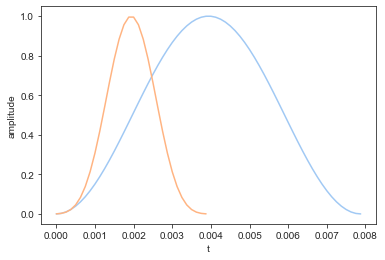

In [7]:
ax = sns.lineplot(y=audio.attrs["window"], x=audio.attrs["t_window"])
ax = sns.lineplot(y=audio.attrs["impulse"], x=audio.attrs["t_impulse"])
_ = ax.set_xlabel("t"), ax.set_ylabel("amplitude")

### Validate

[('Teen Spirt', 1.453), ('Michelle', 1.625)]


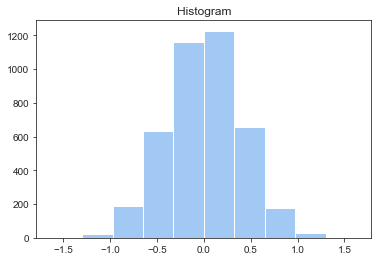

In [8]:
print(amax_per_dim(audio, "track"))
_ = audio.plot.hist()

In [9]:
try:
    assert valid_amp(audio)
except AssertionError as e:
    audio.data = normalize(audio, dim="track")
assert valid_amp(audio)

[('Teen Spirt', 1.0), ('Michelle', 1.0)]


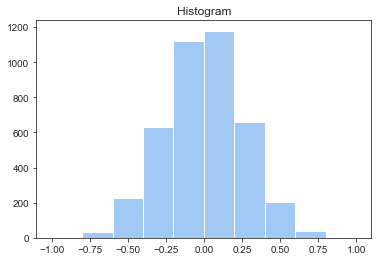

In [10]:
print(amax_per_dim(audio, "track"))
_ = audio.plot.hist()